In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

%matplotlib inline

In [2]:
# Load data to X,y and initial something useful

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
# every row of X is a training sample
# data form X(5000,400),y(50,)
data_path = 'C:\\Users\\39410\\Desktop\\大创项目\\吴恩达机器学习算法数据\\machine-learning-ex3\\ex3\\ex3data1.mat'
data = loadmat(data_path)
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

# number of samples
m = y.size

input_layer_size = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25  # 25 hidden units 
# Note: These doesn't include bias term
num_labels = 10  # 10 labels, from 0 to 9


In [3]:
# Load the pretraining parameters for this exercise

# Load the .mat file, which returns a dictionary 
weights_path = 'C://Users//39410//Desktop//大创项目//吴恩达机器学习算法数据//machine-learning-ex3//ex3//ex3weights.mat'
weights = loadmat(weights_path)

# get the model weights from the dictionary
# Theta1 has size 25 x 401 # theta of the first layer, there are 401 input units,25 hidden units,10 output units
# Theta2 has size 10 x 26 # theta of the second layer, 
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()]) 
#将Theta1和Theta2统一成一个向量
# print(type(nn_params))

In [4]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))
# 可以计算矩阵，也可以计算标量

In [5]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z),(1.0 - sigmoid(z)))
# 可以计算矩阵，也可以计算标量

In [6]:
# # Test sigmoidGrandient
# z = np.array([-1, -0.5, 0, 0.5, 1])
# g = sigmoidGradient(z)
# print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
# print(g)

In [7]:
# Test Python Block
# x1 = np.zeros((5,6))
# x2 = np.array([1,2,3,4,5,6]).reshape(2,3)
# x2[:,1:] += 1
# print(x2)


# Initialize weights and forwardPass

In [8]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    W = epsilon_init * (np.random.rand(L_out,L_in+1) * 2 - 1)
    # generate random number in [-epsilon_init,epsilon_init) 
    # with shape of L_out*(L_in+1)
    return W

In [9]:
# Call randInitializeWeights
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


In [10]:
def forwardPass(Theta1,Theta2,X):
    if X.ndim == 1:
        X = X[None]#将一维的X提升到二维
        
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    
    z2 = np.dot(np.concatenate([np.ones((m, 1)), X], axis = 1),Theta1.T)
    a2 = sigmoid(z2)
    z3 = np.dot(np.concatenate([np.ones((m,1)),a2],axis = 1),Theta2.T)
    a3 = sigmoid(z3)
    
    #print(z2.shape)#(5000,25)
    #print(a2.shape)#(5000,25)
    #print(z3.shape)#(5000,25)
    #print(a3.shape)#(5000,10)
    # return the activation values and z values of hidden layer and output layer
    # for BP training
    return z2,a2,z3,a3

# BP Training

In [11]:
def nnCostFunction(nn_params,#将Theta1和Theta2统一起来
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X,
                   y,
                   lambda_=0.0):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))
    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
    z2,a2,z3,h = forwardPass(Theta1, Theta2, X)     
    
    # Theta1_grad & Theta2_grad is the gradient of Theta
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    # transform y to logic array
    temp = np.zeros((m,num_labels))
    for i in range(m): 
        temp[i][y[i]] = 1
    y = temp# y.shape = (5000,10)
    
    # compute J
    for i in range(m):
        J += np.dot(np.log(h[i]),y[i]) + np.dot(np.log(1-h[i]),(1-y[i]))
    J /= (-m)
    J += (lambda_/(2*m))*(np.sum(Theta2[:,1:]**2)+np.sum(Theta1[:,1:]**2))#正则化J
    # np.log(x)是对整个x矩阵求log，x的每个值都不能为0，
    # 1.可以过滤掉为0的数据
    # 2.可以添加一个很小的值如epsilon = 1e-5
    # bias 单元不正则化里(即Theta1和Theta2的第一列)
    
    # compute grad
    delta3 = h - y
    # delta3.shape = (5000,10)

    delta2 = np.dot(delta3,Theta2) 
    delta2 = delta2[:,1:]# ignore the bias term 
    delta2 = np.multiply(delta2,sigmoidGradient(z2))
    #note that np.multiply means element wise
    #delta2.shape = (5000,25)
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis = 1) #a1.shape = (5000,401)
    a2 = np.concatenate([np.ones((m,1)),a2],axis = 1)#a2.shape = (5000,26)
    Theta1_grad = np.dot(delta2.T,a1) / m
    Theta2_grad = np.dot(delta3.T,a2) / m
    #print(Theta1_grad.shape) #Theta1.shape = (25,401)
    #print(Theta2_grad.shape) #Theta2.shape = (10,26)
    Theta1_grad[:,1:] += (lambda_/m) * Theta1[:,1:]
    Theta2_grad[:,1:] += (lambda_/m) * Theta2[:,1:]
    #note Theta_grad[:,1:] & Theta[:,1:] should have the same shape
    
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

In [12]:
# Test unregular J
# Note that this test should use the pretraining weights and be order executed
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


In [13]:
# Test Weight regularization parameter (we set this to 1 here).
# Note that this test should use the pretraining weights and be order executed
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


# Gradient Checking

In [45]:
def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.
    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.
    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.
    fan_in : int
        The number of incoming connections.
    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    #print(W)
    #print("---------")
    return W

In [40]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.
    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.
    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.
    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape)) 
    # use np.diag to transform (38,) to (38,38) 
    # and perturb is a diagonal matrix with every digonal is e
    # perturb.shape = (38,38)
    #print(perturb)
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    # return the approximation partial derivative of each theta
    # numgrad.shape = (38,)
    # number of (theta1 + theta2) = 38
    return numgrad

In [26]:
def checkNNGradients(nnCostFunction, lambda_=0):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.
    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.
    lambda_ : float (optional)
        The regularization parameter value.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          'Relative Difference: %g' % diff)

In [49]:
# check gradient without regularizetion
checkNNGradients(nnCostFunction)

[[ 0.0841471  -0.02794155 -0.09999902 -0.02879033]
 [ 0.09092974  0.06569866 -0.05365729 -0.09613975]
 [ 0.014112    0.09893582  0.0420167  -0.07509872]
 [-0.07568025  0.04121185  0.09906074  0.01498772]
 [-0.09589243 -0.05440211  0.06502878  0.09129453]]
---------
[[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014112   -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
---------
[[ 0.0841471  -0.02794155 -0.09999902]
 [ 0.09092974  0.06569866 -0.05365729]
 [ 0.014112    0.09893582  0.0420167 ]
 [-0.07568025  0.04121185  0.09906074]
 [-0.09589243 -0.05440211  0.06502878]]
---------
[[ -9.27825235e-03  -9.27825236e-03]
 [ -3.04978709e-06  -3.04978914e-06]
 [ -1.75060082e-04  -1.75060082e-04]
 [ -9.62660618e-05  -9.62660620e-05]
 [  8.89911959e-03   8.89911960e-03]
 [  1.42869427e-05   1.42869443e-05]
 [  2.33146358e-04   2.33146357e-04]
 [  1.17982666e-04   1.17982666e-

In [18]:
# #  Check gradients by running checkNNGradients
# lambda_ = 3
# checkNNGradients(nnCostFunction, lambda_)

# # Also output the costFunction debugging values
# debug_J, _  = nnCostFunction(nn_params, input_layer_size,
#                           hidden_layer_size, num_labels, X, y, lambda_)

# print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
# print('(for lambda = 3, this value should be about 0.576051)')

# Predict

In [19]:
def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = X[None]#将一维的X提升到二维
        
    m = X.shape[0]
    p = np.zeros(m)
    num_labels = Theta2.shape[0]
    
#   X = np.concatenate([np.ones((m, 1)), X], axis=1)  
#     for i in range(m):
#         a1 = X[i]
#         a2 = np.concatenate([np.ones(1),sigmoid(np.dot(Theta1,a0))])
#         a3 = sigmoid(np.dot(Theta2,a1))
#         p[i] = np.argmax(a2)
    a2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis = 1),Theta1.T))
    a3 = sigmoid(np.dot(np.concatenate([np.ones((m,1)),a2],axis = 1),Theta2.T))
    p = np.argmax(a3,axis=1)
    # p是m*1的矩阵，是样本的预测值
    # a3是m*num_lable 的输出数组，是由sigmoid函数计算得出的，一般不为0也不为1(可以log)
    return p

In [20]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [24]:
# use the weights trained by myself 
# it should be about 95%
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))
#print(np.concatenate([np.ones((m, 1)), X], axis=1)  )

Training Set Accuracy: 94.0%


# Random Display

In [22]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


Neural Network Prediction: 6


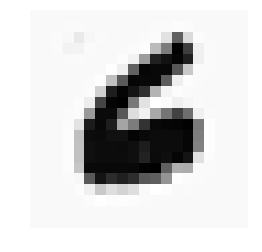

In [23]:
# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')